# Import Packages

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Data Exploration & Analysis

In [2]:
# import data
train_data=pd.read_csv('../data/train.csv')
test_data=pd.read_csv('../data/test.csv')

In [3]:
# get data information
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# get data summaries
print(train_data.describe())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

In [5]:
# get missing or NaN vals
missing_values_df = pd.DataFrame(train_data.isnull().sum().reset_index())
missing_values_df.columns = ['column', 'count']

print(missing_values_df.query('count > 0').sort_values(by = 'count', ascending = False))

          column  count
72        PoolQC   1453
74   MiscFeature   1406
6          Alley   1369
73         Fence   1179
25    MasVnrType    872
57   FireplaceQu    690
3    LotFrontage    259
58    GarageType     81
59   GarageYrBlt     81
60  GarageFinish     81
63    GarageQual     81
64    GarageCond     81
35  BsmtFinType2     38
32  BsmtExposure     38
33  BsmtFinType1     37
31      BsmtCond     37
30      BsmtQual     37
26    MasVnrArea      8
42    Electrical      1


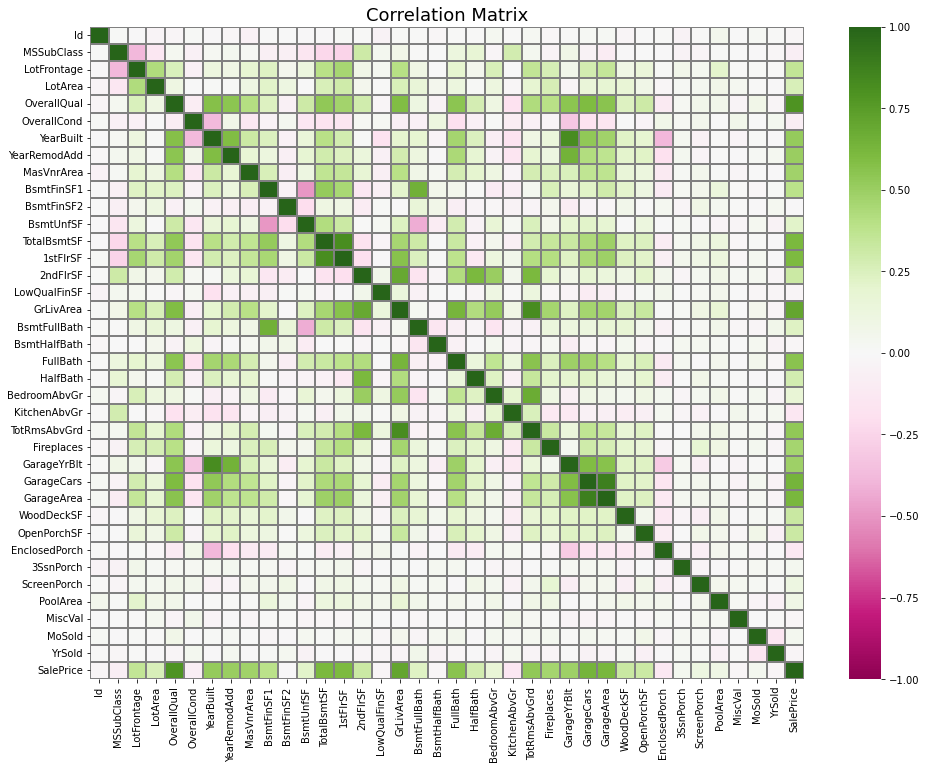

In [6]:
# define numeric features
num_train = train_data.select_dtypes(include='number')

# create correlation plot
corr = num_train.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap='PiYG', cbar=True, vmin=-1, vmax=1, linewidth = 0.4, linecolor = 'grey')
plt.title('Correlation Matrix', fontsize=18)
plt.show()

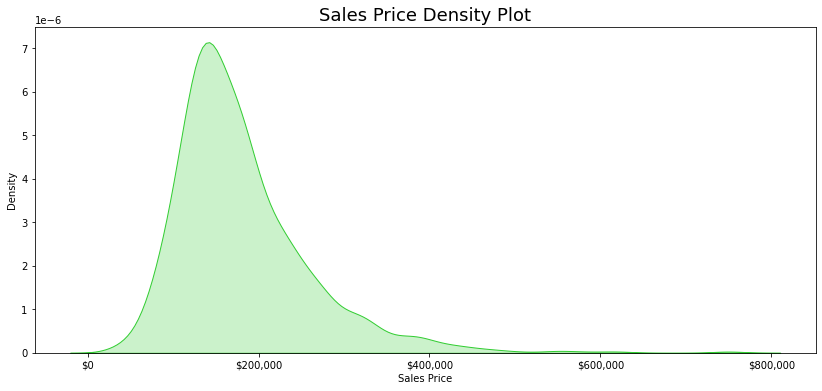

In [7]:
# create density plot
def dollars(x, _):
    return f'${int(x):,}'

plt.figure(figsize=(14, 6))
sns.kdeplot(data=train_data.SalePrice, color='limegreen', fill=True)
plt.xlabel('Sales Price')
plt.gca().xaxis.set_major_formatter(FuncFormatter(dollars))
plt.title('Sales Price Density Plot', fontsize=18)
plt.show()

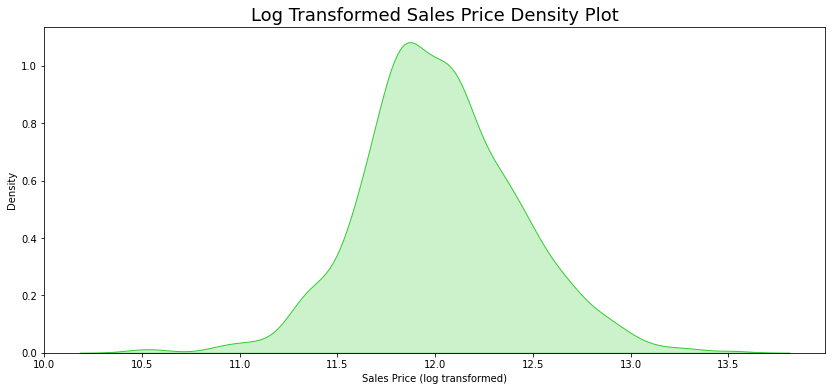

In [8]:
# log transform sale price
train_data_y=np.log(train_data.SalePrice)

# create density plot
plt.figure(figsize=(14, 6))
sns.kdeplot(data=train_data_y, color='limegreen', fill=True)
plt.xlabel('Sales Price (log transformed)')
plt.title('Log Transformed Sales Price Density Plot', fontsize=18)
plt.show()

# Data Preprocessing

In [9]:
# drop Id and garage year built columns
train_data=train_data.drop(columns=['Id','GarageYrBlt'])

# hold test Id for predictions
test_data_id=test_data['Id']

# drop Id and garage year built columns from predictors
test_data=test_data.drop(columns=['Id','GarageYrBlt'])

In [10]:
# define columns with NaN values and their fill values
fill_values = {
    'PoolQC': 'No',
    'MiscFeature': 'No',
    'Alley': 'No',
    'Fence': 'No',
    'MasVnrType': 'No',
    'MasVnrArea': 0,
    'FireplaceQu': 'No',
    'LotFrontage': 0,
    'GarageCond': 'No',
    'GarageType': 'No',
    'GarageFinish': 'No',
    'GarageQual': 'No',
    'BsmtFinType2': 'No',
    'BsmtExposure': 'No',
    'BsmtQual': 'No',
    'BsmtCond': 'No',
    'BsmtFinType1': 'No',
    'Electrical': 'No'
}

# automate filling missing values for train and test data
for column, value in fill_values.items():
    train_data[column].fillna(value, inplace=True)
    test_data[column].fillna(value, inplace=True)

In [11]:
# create feature and outcome structures
train_data_x=train_data.drop(columns=['SalePrice'])
train_data_y=np.log(train_data.SalePrice)

In [12]:
# define columns needing ordinal encoding
ordinal_cols = ['LotShape', 'LandContour','Utilities','LandSlope',  'BsmtQual',  'BsmtFinType1',  'CentralAir',  
                'Functional', 'PoolQC','Fence','FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 
                'ExterCond', 'KitchenQual', 'BsmtExposure', 'HeatingQC','ExterQual', 'BsmtCond', 'SaleCondition',
                'BsmtFinType2']

# define columns needing one_hot encoding
one_hot_cols = ['Street', 'LotConfig','Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
                'Exterior1st', 'Exterior2nd', 'MasVnrType','Foundation', 'Electrical',  'SaleType', 'MSZoning', 
                'Heating', 'GarageType', 'RoofMatl','MiscFeature','Alley']

# define numeric columns
num_cols = train_data.select_dtypes(include='number').columns
num_cols = num_cols.drop('SalePrice')

In [13]:
# define Pipelines to scale, encode, and impute features
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

one_hot_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [14]:
# create column transformer based on pipelines created
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ordinal_pipeline, ordinal_cols),
    ('ohe_p', one_hot_pipeline, one_hot_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [15]:
# fit the column transformer on the training features 
train_data_x=col_trans.fit_transform(train_data_x)

# transform testing features
test_data=pd.DataFrame(col_trans.transform(test_data))

# Model Training and Selection

In [16]:
# define Random Forest Model
random_forest_model=RandomForestRegressor(n_estimators=1000)

# define the parameter grid
random_forest_param_grid = {
    'max_depth': range(5, 20, 5),
    'min_samples_split': range(2, 10, 1),
    'min_samples_leaf': range(1, 5, 1)
}

# set up GridSearchCV
random_forest_grid_search = GridSearchCV(estimator=random_forest_model, 
                           param_grid=random_forest_param_grid,
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1)

# fit models from grid search
random_forest_grid_search.fit(train_data_x, train_data_y)

# identify optimal parameters and corresponding RMSE
print('Random Forest best parameters:', random_forest_grid_search.best_params_)
print('RMSE:', np.sqrt(-1 * random_forest_grid_search.best_score_))

Random Forest best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3}
RMSE: 0.14257986831623554


In [17]:
# define XGBoost model
xgb_model=xgb.XGBRegressor(n_estimators = 1000, eval_metric = 'rmse', enable_categorical=False)

# define the parameter grid
xgb_param_grid = {
    'max_depth': range(3, 10, 1),
    'learning_rate': np.arange(0.01, 0.05, 0.005)
}

# set up GridSearchCV
xgb_grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=xgb_param_grid,
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1)

# fit models from grid search
xgb_grid_search.fit(train_data_x, train_data_y)

# identify optimal parameters and corresponding RMSE
print('XGBoost best parameters:', xgb_grid_search.best_params_)
print('RMSE:', np.sqrt(-1 * xgb_grid_search.best_score_))

XGBoost best parameters: {'learning_rate': 0.034999999999999996, 'max_depth': 3}
RMSE: 0.12399702470277266


In [18]:
# define the SVR model with radial basis function kernel
svr_model = SVR(kernel='rbf')

# set up the parameter grid for hyperparameter tuning
svr_param_grid = {
    'C': np.arange(0.1, 2.0, 0.1),
    'epsilon': np.arange(0.01, 0.1, 0.01)
}

# set up GridSearchCV
svr_grid_search = GridSearchCV(estimator=svr_model, 
                           param_grid=svr_param_grid,
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1)

# fit models from grid search
svr_grid_search.fit(train_data_x, train_data_y)

# identify optimal parameters and corresponding RMSE
print('SVR best parameters:', svr_grid_search.best_params_)
print('RMSE:', np.sqrt(-1 * svr_grid_search.best_score_))

SVR best parameters: {'C': 1.2000000000000002, 'epsilon': 0.03}
RMSE: 0.12208681834514759


# Test Predictions

In [19]:
# define test features
test_data_x=test_data

In [20]:
# Random Forest Model
final_random_forest_model=RandomForestRegressor(n_estimators=1000,
                                                max_depth=15,
                                                min_samples_split=2,
                                                min_samples_leaf=2)

final_random_forest_model.fit(train_data_x, train_data_y)

RandomForestRegressor(max_depth=15, min_samples_leaf=2, n_estimators=1000)

In [21]:
# XGBoost Model
final_xgboost_model=xgb.XGBRegressor(n_estimators = 1000,  
                                     max_depth=3,
                                     learning_rate=0.035,
                                     eval_metric = 'rmse',
                                     enable_categorical=True)

final_xgboost_model.fit(train_data_x, train_data_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.035, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
# SVM Model
final_svr_model=SVR(kernel='rbf',
                    C=1.2,
                    epsilon=0.03
                   )

final_svr_model.fit(train_data_x, train_data_y)

SVR(C=1.2, epsilon=0.03)

In [23]:
# make predictions
y_hat_rf=final_random_forest_model.predict(test_data_x)
y_hat_xgb=final_xgboost_model.predict(test_data_x)
y_hat_svr=final_svr_model.predict(test_data_x)

# compile predictions with testing records
pred_df = pd.DataFrame({
    'Id':test_data_id,
    'rf':np.exp(y_hat_rf),
    'xgb':np.exp(y_hat_xgb),
    'svr':np.exp(y_hat_svr)
})

# average predictions of models to create prediction
pred_df['SalePrice'] = pred_df[['rf','xgb','svr']].mean(axis=1)

# create dataframe and csv for submission
final_df = pd.DataFrame(pred_df[['Id','SalePrice']])
final_df.to_csv('../submissions/submission.csv', index=False)

OSError: Cannot save file into a non-existent directory: '../submissions'